# 🌐 QASM

We can now use Quantum Assembly Language in order to emulate the behaviour of a real quantum circuit.

## 📚 Libraries

In [2]:
# Librerie necessarie
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex
%matplotlib inline

## 🔧 Functions

In [3]:
# Funzioni per la creazione del circuito

def bell_pair(circuit, a, b):
    # Crea una coppia di Bell nel circuito usando i qubit 'a' e 'b'
    circuit.h(a)
    circuit.cx(a, b)
    
def Alice_side(circuit, c, a):
    # Operazioni che compie Alice, dove il qubit 'c' contiene lo stato da teletrasportare
    circuit.barrier()
    circuit.cx(c, a)
    circuit.h(c)
    
def Alice_measure(circuit, c, a):
    # Alice misura i suoi qubit e invia il risultato a Bob
    circuit.barrier()
    circuit.measure(c, 0)
    circuit.measure(a, 1)
    
def Bob_side(circuit, qubit, cr1, cr2):
    # In base al valore dei bit nei registri 1 e 2 (cr1, cr2) Bob decide che porta applicare al qubit passato in ingresso
    circuit.barrier()
    # Vengono applicati i registri se i valori sono '1'
    circuit.x(qubit).c_if(cr2, 1)
    circuit.z(qubit).c_if(cr1, 1)

## ❓ Random State Initialization

In [4]:
# Creazione di uno stato iniziale casuale
# Con QASM si utilizzerà la funzione inversa di Initialize, che anziché portare un qubit da |0> a |psi>
# lo porta da |psi> a |0>. Si potrà verificare quindi che q2 sarà sempre uguale a |0>

psi = random_state(1)
init_gate = Initialize(psi) # Porta dallo stato |0> allo stato |psi>
init_gate.label = "init"
inverse_init_gate = init_gate.gates_to_uncompute() # Porta dallo stato |psi> allo stato |0>

## 🧩 Circuit Initialization

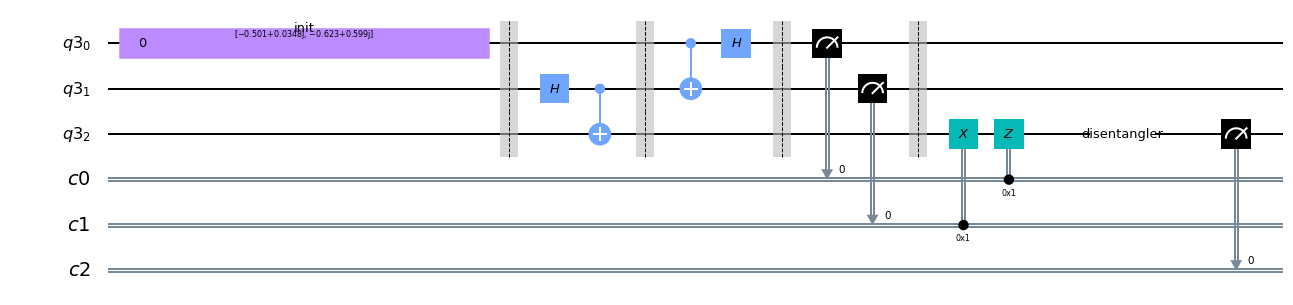

In [5]:
# Creazione del circuito

qr = QuantumRegister(3)
cr1 = ClassicalRegister(1)
cr2 = ClassicalRegister(1)
result = ClassicalRegister(1)
circuit = QuantumCircuit(qr, cr1, cr2, result) # 3 qubit e 3 bit

# Inizializzazione del qubit C da teletrasportare
circuit.append(init_gate, [0])
circuit.barrier()

# Passo 1: creazione della coppia di Bell
bell_pair(circuit, 1, 2)

# Passo 2: Alice agisce sui suoi qubit
Alice_side(circuit, 0, 1)

# Passo 3: Alice misura i qubit ed invia il risultato a Bob
Alice_measure(circuit, 0, 1)

# Passo 4: Bob agisce sul suo qubit in base al risultato della misura di Alice
Bob_side(circuit, 2, cr1, cr2)

# Passo 5: inversione del processo di inizializzazione e misura del valore
circuit.append(inverse_init_gate, [2])
circuit.measure(2,2)

circuit.draw(output = 'mpl')

## ✅ Verification

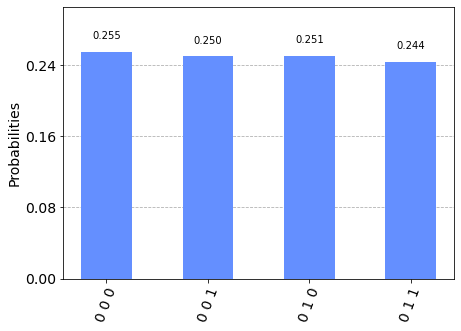

In [6]:
# Verifica del corretto teletrasporto: il bit salvato in 2 deve essere sempre 0

backend = BasicAer.get_backend('qasm_simulator')
counts = execute(circuit, backend, shots = 1024).result().get_counts()
plot_histogram(counts)